In [1]:
import gensim
from gensim.models import Word2Vec
import pandas as pd
import warnings
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from ast import literal_eval
import re

from sklearn.decomposition import PCA

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

import nltk
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
# Create WordNetLemmatizer object
wnl = WordNetLemmatizer()


/var/folders/wl/yn_f16552qvcz999s7pwv5sm0000gn/T/ipykernel_26799/572334254.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
before_df = pd.read_csv("Before_Tokenized.csv")
after_df = pd.read_csv("After_Tokenized.csv")

before_df = before_df[["Subject_ID", "Tweet_ID", "Sentence"]]
after_df = after_df[["Subject_ID", "Tweet_ID", "Sentence"]]

# Function to remove the [CLS] and [SEP]
def trim_sentence(sentence):
    if len(sentence) > 10:  
        return sentence[5:-5]
    else:
        return "" 

# Apply the function to the Sentence column
before_df['Trimmed Sentence'] = before_df['Sentence'].apply(trim_sentence)
after_df['Trimmed Sentence'] = after_df['Sentence'].apply(trim_sentence)

# Concatenate all trimmed sentences into a single string 
before_corpus = before_df['Trimmed Sentence'].str.cat(sep='. ') 
after_corpus = after_df['Trimmed Sentence'].str.cat(sep='. ') 

before_words = word_tokenize(before_corpus)
after_words = word_tokenize(after_corpus)

# Lemmatize all words in a corpus
lemmatized_before = [[wnl.lemmatize(words) for words in before_words]]
lemmatized_after = [[wnl.lemmatize(words) for words in after_words]]

print(lemmatized_before[0][:20])


# df.to_csv("word2vectesting.csv", index=False)


['holy', 'fucking', 'shit', 'criticizing', 'Israel', 'antisemitic', '.', 'IS', 'antisemitic', 'putting', 'holocaustdenying', 'lunatic', 'think', 'Jews', 'control', 'weather', 'Homeland', 'Security', 'Committee', '.']


In [3]:
# Create CBOW model
before_model = gensim.models.Word2Vec(lemmatized_before, min_count=1, vector_size=768, window=5, alpha=0.05)
after_model = gensim.models.Word2Vec(lemmatized_after, min_count=1, vector_size=768, window=5, alpha=0.05)

# Create Skip Gram model
model2 = gensim.models.Word2Vec(before_corpus, min_count=1, vector_size=100, window=5, sg=1)

print(before_model)
print(after_model)

Word2Vec<vocab=930, vector_size=768, alpha=0.05>
Word2Vec<vocab=1847, vector_size=768, alpha=0.05>


In [4]:
# Function to get word vector or a zero vector for unseen words
def get_word_vector(word, model):
    if word in model.wv.vocab:
        return model.wv[word]
    else:
        return [0] * model.vector_size  # Return a zero vector of the same size

def analogy(model, x1, x2, y1):
    result = model.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

# Example usage
word = "Israel"
# vector = get_word_vector(word, before_model)
# print(vector)

print(before_model.wv.most_similar('Palestinian')) # Finding frequently used together words
print(before_model.wv['Israel']) # Getting embeddings


[('.', 0.24310097098350525), ('I', 0.15073072910308838), ('people', 0.1454491764307022), ('risk', 0.14238126575946808), ('job', 0.1419467180967331), ('States', 0.13524410128593445), ('future', 0.13314372301101685), ('t', 0.13238689303398132), ('A', 0.13166256248950958), ('Israel', 0.1253412812948227)]
[-1.97944115e-04 -1.09249738e-03  7.51413754e-04  4.21209115e-04
  1.06715201e-03 -2.58789980e-04 -4.12596681e-04  7.80133763e-04
  1.00850838e-03 -7.57365080e-04  5.05165895e-04 -1.51040964e-03
 -9.00846266e-04 -3.96871590e-04 -1.37706078e-03  6.39876816e-04
 -1.43170910e-04 -3.51177732e-05  2.28320845e-04  1.51217426e-03
  1.59566663e-03 -4.93128282e-05  4.63721692e-04 -8.11317354e-04
 -1.35114358e-03  9.61806101e-04 -3.52222851e-04 -2.34201769e-04
 -7.89561134e-04 -6.83871098e-04  4.96405119e-04 -7.14596128e-04
 -9.56398668e-04  9.76068084e-04  4.14457725e-04  1.13607862e-03
  1.34030101e-03  2.69031792e-04  1.17453188e-03 -6.51517359e-04
 -6.75785763e-04  1.19667978e-03  6.12305244e-0

In [5]:
# Print results
# print("Cosine similarity between 'alice' " + "and 'wonderland' - CBOW : ", before_model.wv.similarity('Israel', 'rude'))

Visualizing word embeddings

In [6]:
def display_pca_scatterplot(model, words=None, title= "", sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.key_to_index.keys()), sample)
        else:
            words = list(model.wv.key_to_index.keys())
        
    word_vectors = np.array([model.wv[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    plt.title(title)
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.0009, y+0.0009, word)
    plt.show()
    

In [ ]:
display_pca_scatterplot(before_model, 
                        ['Israel', 'Palestinian', 'Hamas', 'terrorist'],
                        "Before Embeddings")

display_pca_scatterplot(before_model, sample=300)


KeyError: "Key 'incompetent' not present"

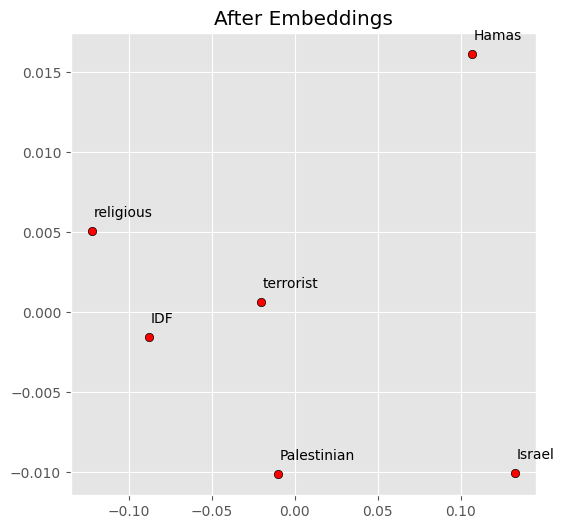

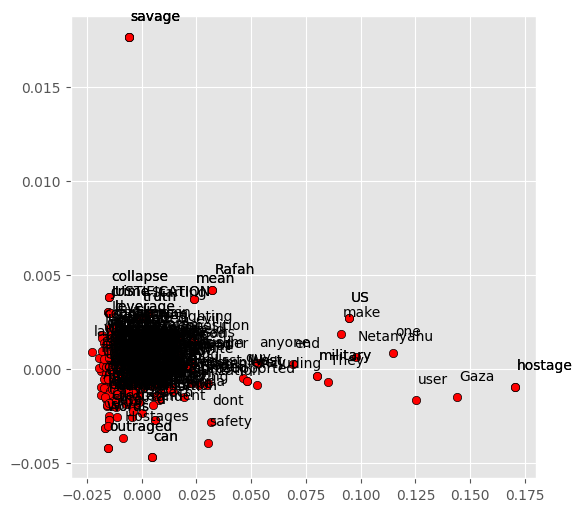

In [8]:
display_pca_scatterplot(after_model, 
                        ['Israel', 'Palestinian', 'IDF', 'Hamas', 'terrorist', 'religious'],
                        "After Embeddings")

display_pca_scatterplot(after_model, sample=300)

In [9]:
# Function to clean and convert embeddings
def clean_embedding(embedding_str):
    # Remove newlines and ensure proper formatting
    cleaned_str = re.sub(r'\s+', ' ', embedding_str).strip()
    try:
        return np.array(literal_eval(cleaned_str))
    except Exception as e:
        print(f"Error converting embedding: {e}")
        return np.array([])

# Load the DataFrame
stereotypes_df = pd.read_csv("../Create Dictionary/Stereotypes_word_embeddings.csv")

# Convert the 'embedding' column to numpy arrays
stereotypes_df['embedding'] = stereotypes_df['embedding'].apply(clean_embedding)

# Compute cosine similarity for each embedding
for index, row in stereotypes_df.iterrows():
    word = row["word"]
    embedding = row["embedding"]
    similarity_with_word2vec = cosine_similarity([embedding], [before_model.wv['israel']])[0][0]
    
    print(f"Word: {word}")
    print(f"Similarity with Word2Vec embedding: {similarity_with_word2vec}")
    print("-----")

# Display the first few rows of the DataFrame
print(stereotypes_df.head())



Error converting embedding: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)
Error converting embedding: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)
Error converting embedding: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)
Error converting embedding: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)
Error converting embedding: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)
Error converting embedding: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)
Error converting embedding: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)
Error converting embedding: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)
Error converting embedding: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)
Error converting embedding: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)
Error converting embedding: invalid syntax. Perhaps you forgot a comma? (<unknow

KeyError: "Key 'israel' not present"